# Tomer and Nir 2024 IMU project
##### Function Declaration:

In [41]:
import numpy as np
from playsound import playsound
from matplotlib import pyplot as plt
from snn.resonator import test_resonator_on_chirp, create_chirp_signal, trained_resonator, simple_resonator

def plot_emitted_spikes(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))
    plt.title('Resonator Output')
    plt.ylabel('Spikes per W500')
    plt.xlabel('Frequency')
    plt.plot(x, y_spikes)

# same, but adds legend (takes x2 more time)    
def plot_emitted_spikes_modified(network, x_stop, freq, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))

    # Plot the data and get a reference to the line object
    line, = plt.plot(x, y_spikes, label=f'Frequency: {freq}')

    # Set plot labels and title
    plt.title('Resonator Output')
    plt.ylabel('Spikes per 500')
    plt.xlabel('Frequency')

    # Create or update the legend
    lines, labels = plt.gca().get_legend_handles_labels()
    if f'Frequency: {freq}' not in labels:
        lines.append(line)
        labels.append(f'Frequency: {freq}')
    plt.legend(lines, labels)
# Call this function to display the plot without closing it
plt.show(block=False)
   
def resonator_output_spikes_on_chirp(my_resonator, freq0, clk_freq, save_figure=False,  neurons_log_potentials=None, neurons_log_spikes=None, step=None):
    neurons_log_potentials = neurons_log_potentials or []
    for i in neurons_log_potentials:
        my_resonator.log_membrane_potential(i)

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    start_freq = 0
    spectrum = 4*freq0
    step = step or 1/clk_freq
    test_size = int(spectrum / step)

    print(start_freq, step, test_size, clk_freq)
    test_resonator_on_chirp(
        my_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    for i in neurons_log_potentials:
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    spikes_window_size = 500
    for i in neurons_log_spikes:
        spikes_neuron = my_resonator.neurons[i]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(test_size)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
        plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
        if save_figure:
            plt.savefig('plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.plot(x, y_spikes)
            plt.show()
            
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size
             
def custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=1, step = None, save_figure=False, path=None, plot=True, c=None):
    resonator.log_out_spikes(-1)
    start_freq = freq0/2
    spectrum = freq0
    step = step or 1 / clk_freq / sample_rate
    test_size = int(spectrum / step)
    spikes_neuron = resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_frequency(
        resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1

    if path is not None:
        np.savez_compressed(path, spikes=y_spikes)

    spikes_window_size = 500
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    # plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes, label=freq0, c=c)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()
        

#Parameters:
clk_freq=1536000
spectrum = 300
step = 1/20000  # To reduce running time, increase step
test_size = int(spectrum / step)

# Resonator Checks:
#### The main objective is to check that we have full coverage of the spectrum

95.4 Type:  <class 'float'>
C:\Users\user1\PycharmProjects\SNN-SCTN\filters4_xi0\united_filters\f_95.4.json
Thetas:  [-117.549, -100.74, -96.393, -85.843] , Weights: [387.993, 160.185, 197.341, 190.822, 177.199] , Leakage Factor:   4 , Clock Frequency:  153600
f is:  95.4 f_clk = 153600 Leakage Period is: 15
160 Type:  <class 'int'>
C:\Users\user1\PycharmProjects\SNN-SCTN\filters4_xi0\united_filters\f_160.json
Thetas:  [-19.184, -17.323, -15.152, -15.803] , Weights: [63.808, 26.451, 34.141, 30.497, 31.678] , Leakage Factor:   4 , Clock Frequency:  1536000
f is:  163 f_clk = 1536000 Leakage Period is: 92


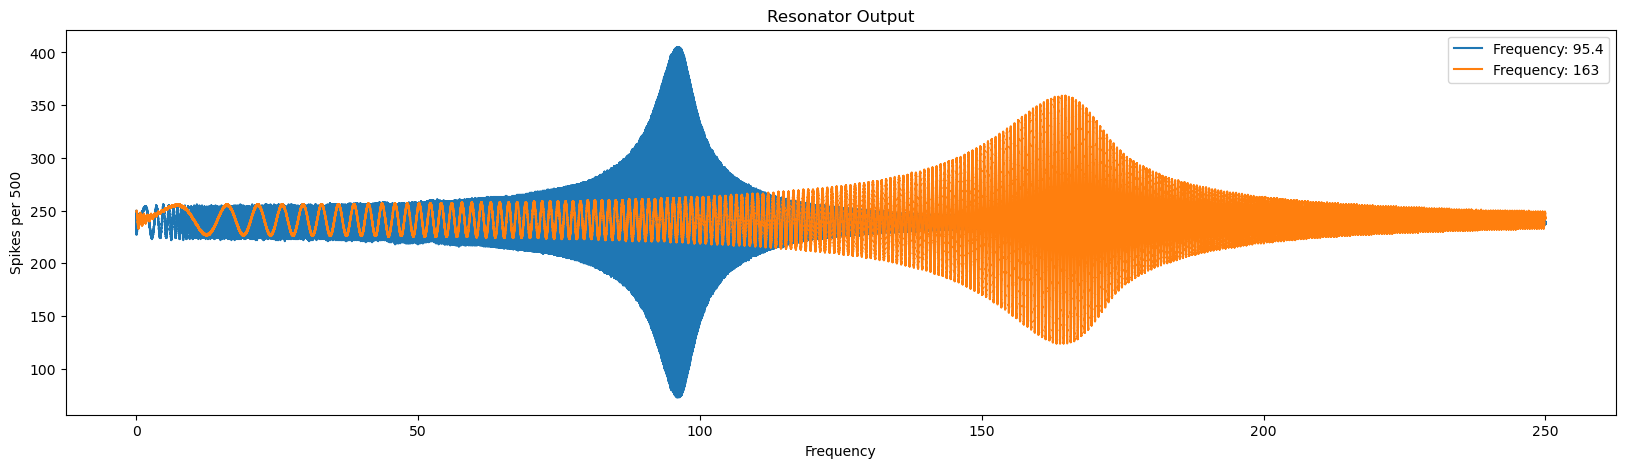

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

#for one frequency:
resonators_freqs = [95.4,163]

#for an evenly spaced frequencies:
#resonators_freqs = [i for i in range(40,260,15)]

#for the exact location of the resonators:
#resonators_freqs = [6.94, 8.98, 10.5, 15.9, 19.5, 25, 30.5, 34.7, 40.2, 46.2,  52.6, 63.6, 69.4, 76.3, 89.8, 95.4, 110, 128, 130, 160, 175, 195, 221, 250]



spectrum = 250
for i, freq in enumerate(resonators_freqs):
    resonator = trained_resonator(freq0=freq)
    resonator.log_out_spikes(-1) # log the spikes emitted from the last neuron
    if freq < 10:
        step = 1/30000
        clk_freq = 15360
    elif 100 > freq >= 10:
        step = 1/30000
        clk_freq = 153600 
    else:
        step = 1/15000
        clk_freq = 1536000         
     
    test_size = int(spectrum / step)
    
    test_resonator_on_chirp(
        resonator,
        start_freq=0,
        test_size=test_size,
        clk_freq=clk_freq,
        step=step)
    #plot_emitted_spikes(resonator, spectrum)
    #(do not release this line)modified takes x2 time, but shows legend:
    plot_emitted_spikes_modified(resonator, spectrum, freq)
    
#playsound("C:\\Users\\user1\\University_ 4th year\\project\\mixkit-correct-answer-reward-952.wav")